In [1]:
############
# Imports #
############

import json
import os

import torch
import wandb
from torch.utils.data import DataLoader

from model.cnn_classifier import model_4D
from model.finetune import FinetuneLoop
from model.pseudomask import Pseudomasks
from model.train import ClassifierTrainLoop
from utils.data_modules import ImageDataset, TestSet, filter_dataset

artifact_path = 'nadjaflechner/VGG_CAMs/model:v31'

api = wandb.Api()
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
model = model_4D()
model.load_state_dict(state_dict)
model.eval()

testset_dir = '/Users/nadja/Documents/UU/Thesis/Data/Verified_GTs'
depth_layer = 'hs'
normalize = True
finetune = False

test_set = TestSet(depth_layer, testset_dir, normalize)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
wandb:   1 of 1 files downloaded.  


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


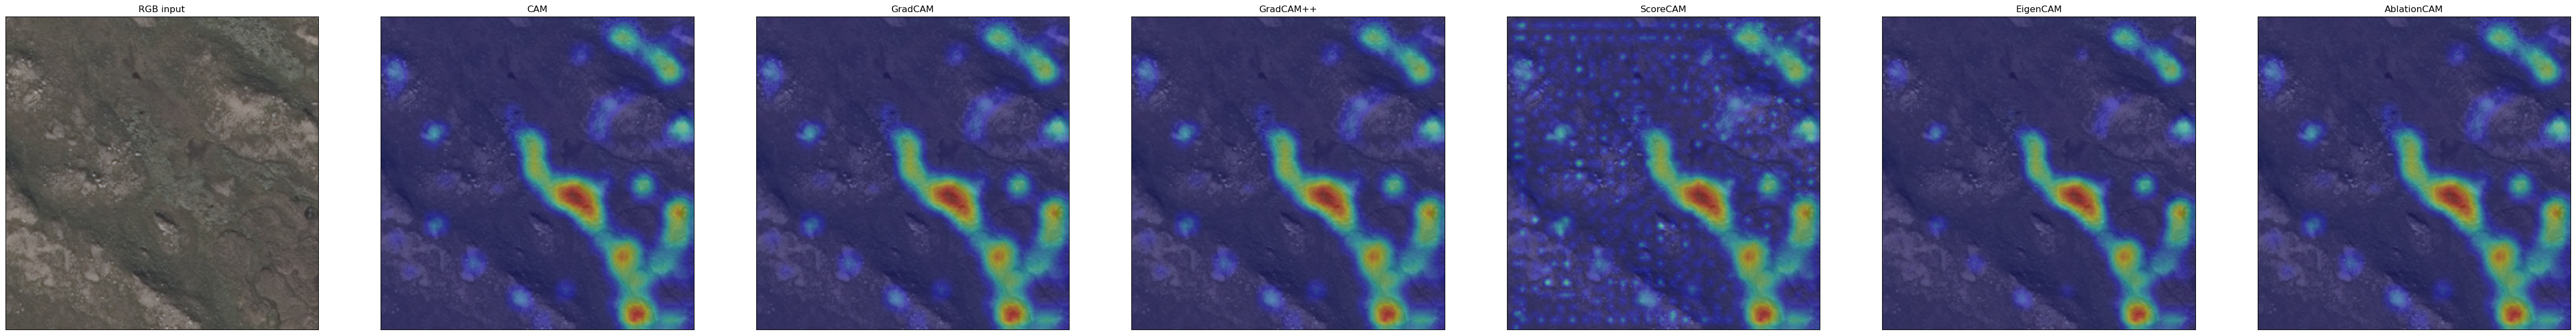

In [49]:
from utils.data_modules import SaveFeatures
from torch.autograd import Variable
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, EigenCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np


# im, lab, perc, gt_mask = next(iter(test_loader))
for im, lab, perc, gt_mask in test_loader:
    if 0.1>perc>0.05: 
            
        #get the last convolution
        sf = SaveFeatures(model.features[-2])
        im = Variable(im)
        outputs = model(im)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach()#.numpy()

        pals_acts = torch.nn.functional.interpolate(
            input = arr[:,1,:,:].unsqueeze(1),
            scale_factor = im.shape[3]/arr.shape[3],
            mode='bilinear'
        ).cpu().detach()

        # Initiate all CAMs
        target_layers = [model.features[-2]]  # Use the last convolutional layer
        gradcam = GradCAM(model=model, target_layers=target_layers)
        scorecam = ScoreCAM(model=model, target_layers=target_layers)
        eigencam = EigenCAM(model=model, target_layers=target_layers)
        gradcamplusplus = GradCAMPlusPlus(model=model, target_layers=target_layers)
        ablationcam = AblationCAM(model=model, target_layers=target_layers)

        # make the figure

        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, ax = plt.subplots(1,7, figsize = (60,15))

        ax[0].imshow(cpu_img[:,:,:3])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'RGB input')

        ax[1].imshow(cpu_img[:,:,:3])
        ax[1].imshow(pals_acts.view(pals_acts.shape[3], pals_acts.shape[3], 1), alpha=.4, cmap='jet')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'CAM')

        cams = [gradcam, gradcamplusplus, scorecam, eigencam, ablationcam]
        cams_strs = ['GradCAM',  'GradCAM++', 'ScoreCAM', 'EigenCAM', 'AblationCAM']
        axs = [2,3,4,5,6]

        for cam, name, axis in zip (cams, cams_strs, axs):
            activation_map = cam(input_tensor=im, targets = [ClassifierOutputTarget(1)])
            ax[axis].imshow(cpu_img[:,:,:3])
            ax[axis].imshow(np.transpose(activation_map, (1,2,0)), alpha=.4, cmap='jet')
            ax[axis].set_xticks([])
            ax[axis].set_yticks([])
            ax[axis].set_title(name)

        break


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2C8BF30B-D1BA-315D-BF33-9DF6F3757AB3> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


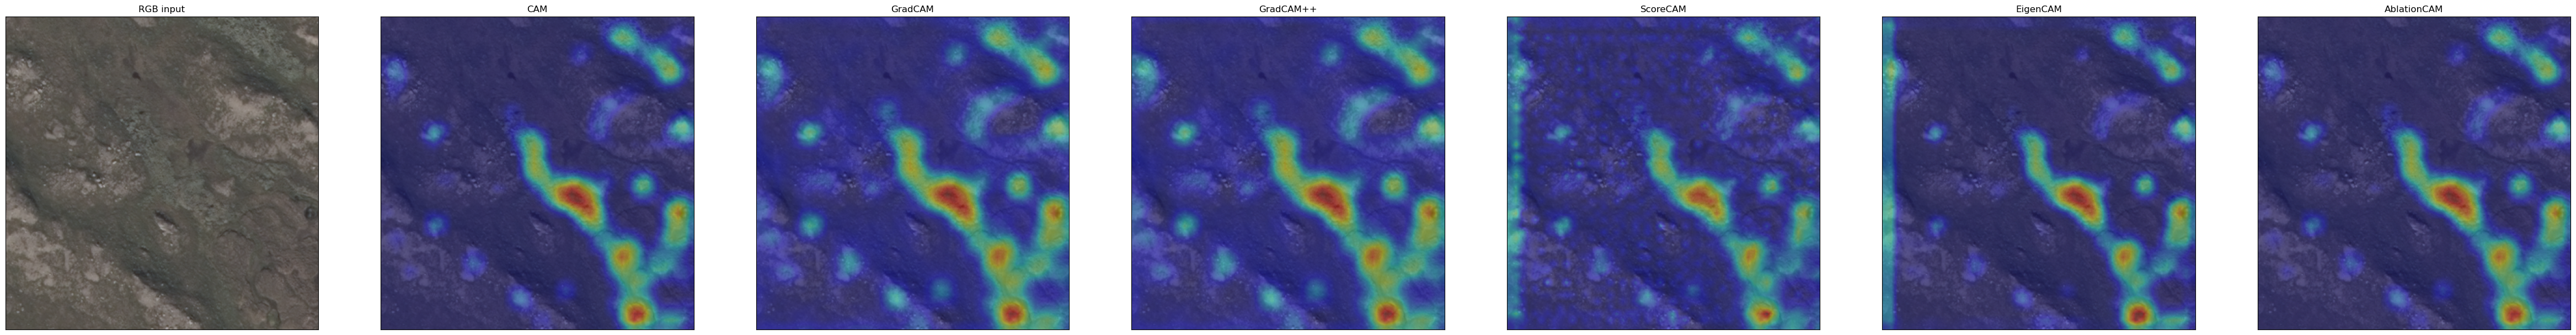

In [3]:
from utils.data_modules import SaveFeatures
from torch.autograd import Variable
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, EigenCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np


# im, lab, perc, gt_mask = next(iter(test_loader))
for im, lab, perc, gt_mask in test_loader:
    if 0.1>perc>0.05: 
            
        #get the last convolution
        sf = SaveFeatures(model.features[-2])
        im = Variable(im)
        outputs = model(im)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach()#.numpy()

        pals_acts = torch.nn.functional.interpolate(
            input = arr[:,1,:,:].unsqueeze(1),
            scale_factor = im.shape[3]/arr.shape[3],
            mode='bilinear'
        ).cpu().detach()

        # Initiate all CAMs
        target_layers = [model.features[-2],model.features[-4],model.features[-7]]  # Use the last convolutional layer
        gradcam = GradCAM(model=model, target_layers=target_layers)
        scorecam = ScoreCAM(model=model, target_layers=target_layers)
        eigencam = EigenCAM(model=model, target_layers=target_layers)
        gradcamplusplus = GradCAMPlusPlus(model=model, target_layers=target_layers)
        ablationcam = AblationCAM(model=model, target_layers=[model.features[-2]])

        # make the figure

        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, ax = plt.subplots(1,7, figsize = (60,15))

        ax[0].imshow(cpu_img[:,:,:3])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'RGB input')

        ax[1].imshow(cpu_img[:,:,:3])
        ax[1].imshow(pals_acts.view(pals_acts.shape[3], pals_acts.shape[3], 1), alpha=.4, cmap='jet')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'CAM')

        cams = [gradcam, gradcamplusplus, scorecam, eigencam]
        cams_strs = ['GradCAM',  'GradCAM++', 'ScoreCAM', 'EigenCAM']
        axs = [2,3,4,5]

        for cam, name, axis in zip (cams, cams_strs, axs):
            activation_map = cam(input_tensor=im, targets = [ClassifierOutputTarget(1)])
            ax[axis].imshow(cpu_img[:,:,:3])
            ax[axis].imshow(np.transpose(activation_map, (1,2,0)), alpha=.4, cmap='jet')
            ax[axis].set_xticks([])
            ax[axis].set_yticks([])
            ax[axis].set_title(name)


        activation_map = ablationcam(input_tensor=im, targets = [ClassifierOutputTarget(1)])
        ax[6].imshow(cpu_img[:,:,:3])
        ax[6].imshow(np.transpose(activation_map, (1,2,0)), alpha=.4, cmap='jet')
        ax[6].set_xticks([])
        ax[6].set_yticks([])
        ax[6].set_title('AblationCAM')

        break
